In [ ]:
pip install tpot

Distribution des classes dans 'y': (array([0, 1], dtype=int64), array([1000000,    8213], dtype=int64))
Nouvelle distribution des classes : (array([0, 1], dtype=int64), array([800000, 800000], dtype=int64))
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Meilleurs paramètres :  {'C': 0.1, 'penalty': 'l2'}
Meilleur score F1 :  0.989282748898412
[[199673    327]
 [    71   1572]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200000
           1       0.83      0.96      0.89      1643

    accuracy                           1.00    201643
   macro avg       0.91      0.98      0.94    201643
weighted avg       1.00      1.00      1.00    201643



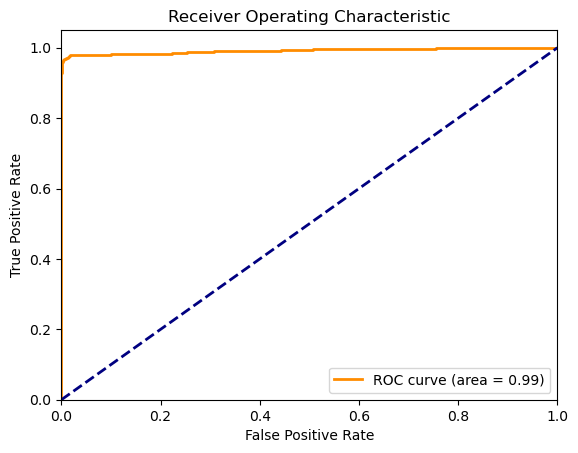

In [18]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Chargement et préparation des données
datafraud = pd.read_csv('fichierfraudnet.csv', sep=';', quotechar='"', on_bad_lines='skip', decimal=',')
type_mapping = {'CASH_OUT': 1, 'PAYMENT': 2, 'CASH_IN': 3, 'TRANSFER': 4, 'DEBIT': 5}
datafraud['type'] = datafraud['type'].map(type_mapping)

X = datafraud[['type', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = datafraud['isFraud']

# S'assurer que y contient deux classes distinctes
print("Distribution des classes dans 'y':", np.unique(y, return_counts=True))

# Division des données de manière stratifiée pour maintenir la proportion des classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Application de SMOTE pour le suréchantillonnage des données de la classe minoritaire
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Affichage de la nouvelle distribution des classes
print("Nouvelle distribution des classes :", np.unique(y_resampled, return_counts=True))

# Configuration de la recherche d'hyperparamètres
model = LogisticRegression(max_iter=10000, random_state=42)
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l2']
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Affichage des meilleurs paramètres et du score
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur score F1 : ", grid_search.best_score_)

# Évaluation sur l'ensemble de test avec le meilleur modèle
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Tracé de la courbe ROC
y_scores = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Sauvegarder le meilleur modèle
filename = 'modeleregressionlog.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)